### Report to 11020PHYS401200-Computational-Physics

### Part C : Contact Transfer Matrix in Y,X direction by CYTNX ( without truncation )

* Author : Yen-Tung Lin
* ID : 109022802

### Reference
* Complexity and Criticality, Kim Christensen

### Model

* Classical Ising Model in 2 D : E = J $\sum_{<i,j>}S^{z}_{i}S^{z}_{j}$


### To Calculate

* Transfer Matrix
* Eigenvalues of Transfer Matrix
* Corrlation length $\xi$=$\frac{1}{\log(\lambda_{0}/\lambda_{1})}$
* Determine the intersection of $\xi$ and do extrapolate to compare with exact Tc = $\frac{2}{\log(1+\sqrt(2)))}$

### Import

In [1]:
import os
import math
import random
import cytnx as cy
from scipy.optimize import curve_fit
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chocolate':            '#D2691E',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', 'x-', '^-', 's-', 'p-', '*-', 'h-']   ## marker array

## Construct transfer matrix through Tensor Methods

### Define function : Print Diagram and Element

In [3]:
def ut_print(ut):
    ut.print_diagram()
    print(ut.get_block().numpy())

### Define function : Xmerge and Ymerge function

In [4]:
def Xmerge(TL,TR):
    Xmerge = cy.Network("network/Xmerge.net")
    Xmerge.PutUniTensors(['TL','TR'], [TL,TR])

    Uni_Tx = Xmerge.Launch()
    Uni_Tx.combineBonds([0,4])
    Uni_Tx.combineBonds([3,5])
    return Uni_Tx

def Ymerge(TU,TD):
    Xmerge = cy.Network("network/Ymerge.net")
    Xmerge.PutUniTensors(['TU','TD'], [TU,TD])

    Uni_Ty = Xmerge.Launch()
    Uni_Ty.combineBonds([1,10])
    Uni_Ty.combineBonds([2,11])
    return Uni_Ty

def T(t):
    # t = 1
    # J = 1
    # beta = 1/t
    m = np.array([[np.sqrt(np.cosh(1/t)),np.sqrt(np.sinh(1/t))],
                    [np.sqrt(np.cosh(1/t)),-np.sqrt(np.sinh(1/t))]])
    m_transpose = np.copy(m.transpose())
    CyT_M = cy.from_numpy(m)
    Uni_M = cy.UniTensor(CyT_M, rowrank = 1)
    # Uni_M.print_diagram()
    # np.array([[np.sqrt(np.cosh(1/t)),np.sqrt(np.sinh(1/t))],[np.sqrt(np.cosh(1/t)),-np.sqrt(np.sinh(1/t))]])
    CyT_M_transpose = cy.from_numpy(m_transpose)
    Uni_M_transpose = cy.UniTensor(CyT_M_transpose, rowrank = 1)
    # Uni_M_transpose.print_diagram()

    Uni_M_up = Uni_M_transpose.clone()
    Uni_M_up.set_name("Uni_M_up")
    # ut_print(Uni_M_up)

    Uni_M_left = Uni_M_transpose.clone()
    Uni_M_left.set_name("Uni_M_left")
    # ut_print(Uni_M_left)

    Uni_M_right = Uni_M.clone()
    Uni_M_right.set_name("Uni_M_right")
    # ut_print(Uni_M_right)

    Uni_M_down = Uni_M.clone()
    Uni_M_down.set_name("Uni_M_down")
    # ut_print(Uni_M_down)

    delta = np.zeros((2,2,2,2))
    delta[0,0,0,0] = delta[1,1,1,1] = 1

    Delta = cy.from_numpy(delta)
    UniDelta = cy.UniTensor(Delta, rowrank = 2)
    UniDelta.set_labels([0,1,2,3])
    UniDelta.set_name("UniDelta")
    # ut_print(UniDelta)

    M_network = cy.Network("network/T.net")
    M_network.PutUniTensors(['mu','ml','mr','md','delta'], [Uni_M_up,Uni_M_left,Uni_M_right,Uni_M_down,UniDelta])
    # print(M_network)
    Uni_T=M_network.Launch()
    Uni_T.set_name("Uni_T")
    # CyT_T = Uni_T.get_block()
    # ut_print(Uni_T)

    Uni_T_trace = Uni_T.clone().Trace(0, 3)
    return Uni_T, Uni_T_trace

def Identiy(L):
    np_I = np.identity(2**L)
    cy_I = cy.from_numpy(np_I)
    uni_I = cy.UniTensor(cy_I,rowrank=1)
    return uni_I

### Define M and Contract them to Build T

* $M = \begin{pmatrix}
     \sqrt{\cosh(\beta J)} & \sqrt{\sinh(\beta J)}\\
     \sqrt{\cosh(\beta J)} & -\sqrt{\sinh(\beta J)}\\
     \end{pmatrix}$

In [5]:
t = 1
J = 1
beta = 1/t
M = np.array([[np.sqrt(math.cosh(beta*J)), np.sqrt(math.sinh(beta*J))],
                [np.sqrt(math.cosh(beta*J)),-np.sqrt(math.sinh(beta*J))]])

* $T_{cy}$

In [6]:
t=1
m = np.array([[np.sqrt(np.cosh(1/t)),np.sqrt(np.sinh(1/t))],
                [np.sqrt(np.cosh(1/t)),-np.sqrt(np.sinh(1/t))]])
m_transpose = np.copy(m.transpose())
CyT_M = cy.from_numpy(m)
Uni_M = cy.UniTensor(CyT_M, rowrank = 1)
Uni_M.print_diagram()
# np.array([[np.sqrt(np.cosh(1/t)),np.sqrt(np.sinh(1/t))],[np.sqrt(np.cosh(1/t)),-np.sqrt(np.sinh(1/t))]])
CyT_M_transpose = cy.from_numpy(m_transpose)
Uni_M_transpose = cy.UniTensor(CyT_M_transpose, rowrank = 1)
Uni_M_transpose.print_diagram()

Uni_M_up = Uni_M_transpose.clone()
Uni_M_up.set_name("Uni_M_up")
ut_print(Uni_M_up)

Uni_M_left = Uni_M_transpose.clone()
Uni_M_left.set_name("Uni_M_left")
ut_print(Uni_M_left)

Uni_M_right = Uni_M.clone()
Uni_M_right.set_name("Uni_M_right")
ut_print(Uni_M_right)

Uni_M_down = Uni_M.clone()
Uni_M_down.set_name("Uni_M_down")
ut_print(Uni_M_down)

delta = np.zeros((2,2,2,2))
delta[0,0,0,0] = delta[1,1,1,1] = 1

Delta = cy.from_numpy(delta)
UniDelta = cy.UniTensor(Delta, rowrank = 2)
UniDelta.set_labels([0,1,2,3])
UniDelta.set_name("UniDelta")
ut_print(UniDelta)

M_network = cy.Network("network/T.net")
M_network.PutUniTensors(['mu','ml','mr','md','delta'], [Uni_M_up,Uni_M_left,Uni_M_right,Uni_M_down,UniDelta])
print(M_network)

Uni_T=M_network.Launch()
Uni_T.set_name("Uni_T")
CyT_T = Uni_T.get_block()
ut_print(Uni_T)

Uni_T_Ytrace = Uni_T.clone().Trace(0, 3)
Uni_T_Xtrace = Uni_T.clone().Trace(1, 2)

-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 1  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 1  
           \             /     
            -------------      
-----------------------
tensor Name : Uni_M_up
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 1  
           \             /     
            -------------      
[[ 1.24220797  1.24220797]
 [ 1.08406697 -1.08406697]]
-----------------------
tensor Name : Uni_M_left
tensor Rank : 2
bl

### Y direction Iteration

#### Dictionary to store Tensor

In [7]:
Uni_T_dic = {}
Uni_T_Xtrace_dic = {}
Uni_T_Ytrace_dic = {}
EIGVLE_Xtrace_dic = {}
EIGVLE_Ytrace_dic = {}

Uni_T_dic[(1,1)] = Uni_T
Uni_T_Ytrace_dic[(1,1)] = Uni_T_Ytrace
Uni_T_Xtrace_dic[(1,1)] = Uni_T_Xtrace

EIGVLE_Ytrace_dic[(1,1)], v = np.linalg.eigh(Uni_T_Ytrace.get_block().numpy())
EIGVLE_Xtrace_dic[(1,1)], v = np.linalg.eigh(Uni_T_Xtrace.get_block().numpy())

In [8]:
TU = Uni_T.clone()
TD = Uni_T.clone()
TL = Uni_T.clone()
TR = Uni_T.clone()

for y_i in range(1,9):
    if(y_i == 1):
        Uni_T_temp2 = TD
        # Uni_T_temp2.print_diagram()
        Uni_T_dic[(1,y_i)] = Uni_T_temp2.clone()
        Uni_T_Ytrace_dic[(1,y_i)] = Uni_T_temp2.Trace(0,3).clone()
        Uni_T_Xtrace_dic[(1,y_i)] = Uni_T_temp2.Trace(1,2).clone()
        EIGVLE_T_Ytrace, v  = la.eigh(Uni_T_temp2.Trace(0,3).get_block().numpy())
        EIGVLE_T_Xtrace, v  = la.eigh(Uni_T_temp2.Trace(1,2).get_block().numpy())
        # print("EIGVLE_T_trace",EIGVLE_T_trace)
        EIGVLE_Ytrace_dic[(1,y_i)] = EIGVLE_T_Ytrace
        EIGVLE_Xtrace_dic[(1,y_i)] = EIGVLE_T_Xtrace
        print("EIGVLE_Ytrace_dic[(1,%d)]" %(y_i), EIGVLE_Ytrace_dic[(1,y_i)])
        print("EIGVLE_Xtrace_dic[(1,%d)]" %(y_i), EIGVLE_Xtrace_dic[(1,y_i)])
                # Uni_T_temp = tUni_T_dic.trace(0,3).clone()
    else:
        Uni_T_temp1 = Uni_T_temp2.clone()
        Uni_T_temp2 = Ymerge(TU,Uni_T_temp1)
        Uni_T_dic[(1,y_i)] = Uni_T_temp2.clone()
        Uni_T_Ytrace_dic[(1,y_i)] = Uni_T_temp2.Trace(0,3).clone()
        Uni_T_Xtrace_dic[(1,y_i)] = Uni_T_temp2.Trace(1,2).clone()
        EIGVLE_Ytrace_dic[(1,y_i)], v = la.eigh(Uni_T_temp2.Trace(0,3).get_block().numpy())    
        EIGVLE_Xtrace_dic[(1,y_i)], v = la.eigh(Uni_T_temp2.Trace(1,2).get_block().numpy())    
        print("EIGVLE_Ytrace_dic[(1,%d)]" %(y_i),EIGVLE_Ytrace_dic[(1,y_i)][-1],EIGVLE_Ytrace_dic[(1,y_i)][-2],EIGVLE_Ytrace_dic[(1,y_i)][-3],EIGVLE_Ytrace_dic[(1,y_i)][-4])
        print("EIGVLE_Xtrace_dic[(1,%d)]" %(y_i),EIGVLE_Xtrace_dic[(1,y_i)])

# for x_i in range(1,9):


EIGVLE_Ytrace_dic[(1,1)] [6.3890561 8.3890561]
EIGVLE_Xtrace_dic[(1,1)] [6.3890561 8.3890561]
EIGVLE_Ytrace_dic[(1,2)] 55.67133903078335 53.598150033144236 0.9816843611112649 0.9451266412496171
EIGVLE_Xtrace_dic[(1,2)] [40.82003784 70.37626223]
EIGVLE_Ytrace_dic[(1,3)] 404.96291155067024 402.73718285921115 9.1439242463575 8.235405176805376
EIGVLE_Xtrace_dic[(1,3)] [260.80151169 590.39041189]
EIGVLE_Ytrace_dic[(1,4)] 2986.3464606345447 2983.880781917964 76.93108995267718 69.08727602564353
EIGVLE_Xtrace_dic[(1,4)] [1666.27548887 4952.81828561]
EIGVLE_Ytrace_dic[(1,5)] 22066.25975855403 22063.453187003837 608.6745646308515 556.5041260627016
EIGVLE_Xtrace_dic[(1,5)] [10645.92757469 41549.47044577]
EIGVLE_Ytrace_dic[(1,6)] 163096.88997560178 163093.62216038085 4679.432696681765 4354.94922679445
EIGVLE_Xtrace_dic[(1,6)] [ 68017.42849984 348560.83845042]
EIGVLE_Ytrace_dic[(1,7)] 1205541.7313011868 1205537.855434587 35447.41676859824 33462.15651738923
EIGVLE_Xtrace_dic[(1,7)] [ 434567.16639047

In [9]:
Uni_T_dic.clear()
Uni_T_Xtrace_dic.clear()
Uni_T_Ytrace_dic.clear()
EIGVLE_Xtrace_dic.clear()
EIGVLE_Ytrace_dic.clear()

### Y iteration & Temperature Iterartion

#### Dictionary to store Tensor

In [10]:
Uni_T_dic = {}
Uni_T_trace_dic = {}
EIGVLE_dic = {}

In [11]:
L = 9
Lylist = np.linspace(1,L,L,dtype=int)
t = np.linspace(1,3,81)
corr = np.zeros((len(Lylist),len(t)),dtype=float)
corr1 = np.zeros((len(Lylist),len(t)),dtype=float)

Lambda = np.zeros((len(Lylist),2),dtype=float)
for t_i in range(len(t)):
    Uni_T, y = T(t[t_i])
    TU = Uni_T.clone()
    TD = Uni_T.clone()
    TL = Uni_T.clone()
    TR = Uni_T.clone()

    for y_i in range(len(Lylist)):
        Ly = Lylist[y_i]
        # print("y_i",y_i)
        if(Ly == 1):
            Uni_T_temp2 = TD
            Uni_T_dic[(1,Ly)] = Uni_T_temp2.clone()

            Uni_I = Identiy(1)
            UniTrace = cy.Network("./network/Ytrace.net")
            UniTrace.PutUniTensors(['T','I'], [Uni_T_temp2,Uni_I])
            Uni_T_temp2_Trace = UniTrace.Launch()
            Uni_T_trace_dic[(1,Ly)] = Uni_T_temp2_Trace.clone()

            EIGVLE_T_trace, v = la.eigh(Uni_T_temp2.Trace(0,3).get_block().numpy())
            EIGVLE_dic[(1,Ly)] = EIGVLE_T_trace

            Lambda[y_i,0] = np.sort(EIGVLE_dic[(1,Ly)])[-1]
            Lambda[y_i,1] = np.sort(EIGVLE_dic[(1,Ly)])[-2]
            E0 = -np.log(Lambda[y_i,0])
            E1 = -np.log(Lambda[y_i,1])
            corr[y_i,t_i] = 1/(E1-E0)
            corr1[y_i,t_i] = 1/(np.log(Lambda[y_i,0]/Lambda[y_i,1]))
        else:
            Uni_T_temp1 = Uni_T_temp2.clone()
            Uni_T_temp2 = Ymerge(TU,Uni_T_temp1)
            Uni_T_dic[(1,Ly)] = Uni_T_temp2.clone()

            Uni_I = Identiy(1)
            UniTrace = cy.Network("./network/Ytrace.net")
            UniTrace.PutUniTensors(['T','I'], [Uni_T_temp2,Uni_I])
            Uni_T_temp2_Trace = UniTrace.Launch()

            Uni_T_trace_dic[(1,Ly)] = Uni_T_temp2_Trace.clone()
            EIGVLE_dic[(1,Ly)], v = la.eigh(Uni_T_temp2.Trace(0,3).get_block().numpy())  

            Lambda[y_i,0] = np.sort(EIGVLE_dic[(1,Ly)])[-1]
            Lambda[y_i,1] = np.sort(EIGVLE_dic[(1,Ly)])[-2]
            E0 = -np.log(Lambda[y_i,0])
            E1 = -np.log(Lambda[y_i,1])
            corr[y_i,t_i] = 1/(E1-E0)
            corr1[y_i,t_i] = 1/(np.log(Lambda[y_i,0]/Lambda[y_i,1]))


In [55]:
np.save("corr_Y_t_1~3(81)_L2~9.npy", corr)
np.save("Lambda_Y_t_1~3(81)_L~9.npy", Lambda)

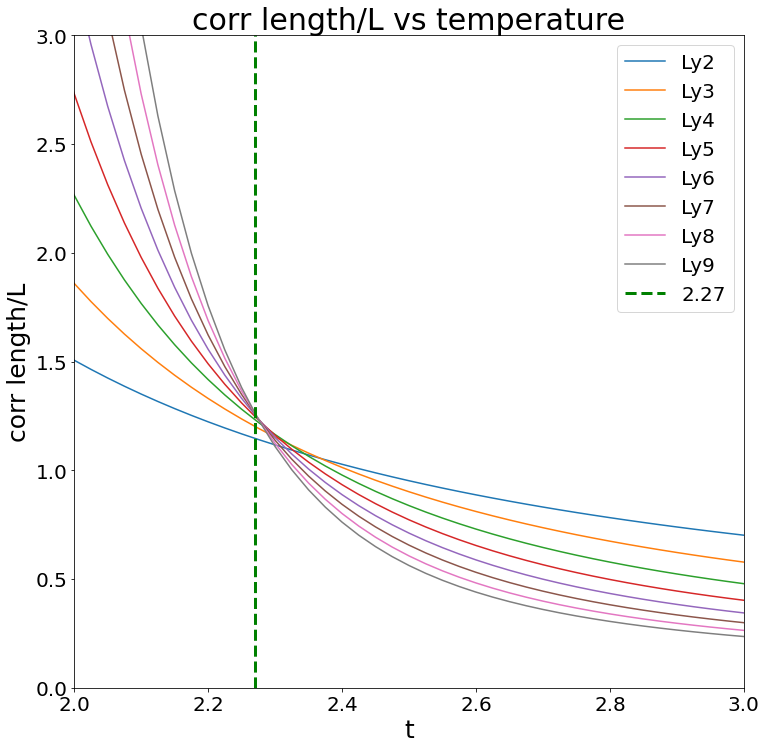

In [12]:
plt.figure(figsize = (12,12))
plt.title("corr length/L vs temperature", fontsize = 30)

for l in range(1,len(Lylist)):
    plt.plot(t[:], corr[l,:]/Lylist[l], label = "Ly%d" %(Lylist[l]))

plt.xlim(2,3)
plt.xticks(fontsize = 20 )
plt.xlabel("t",fontsize = 25)
plt.axvline(x=2.27,c='green',ls='--',lw=3,label="2.27")
plt.ylim(0,3)
plt.yticks(fontsize = 20 )
plt.ylabel("corr length/L",fontsize = 25)
plt.legend(fontsize = 20)

### Search T* Intersection & Expolation 

In [13]:
Xintersection = np.zeros(len(corr[:,0]) - 1)
Yintersection = np.zeros(len(corr[:,0]) - 1)
L_inverse = []

for l in range(1,len(Lylist)-1):
    Ly1 = Lylist[l]
    Ly2 = Lylist[l+1]
    # print("l",l)
    # print("Ly1",Ly1)
    # print("Ly2",Ly2)

    L_inverse.append(1/Ly1)
    for t_i in range(len(t)-1):

        if((corr[l+1,t_i]/Ly2-corr[l,t_i]/Ly1)*(corr[l+1,t_i+1]/Ly2-corr[l,t_i+1]/Ly1) < 0):

            y=[corr[l+1,t_i]/Ly2,corr[l+1,t_i+1]/Ly2]
            x=[t[t_i],t[t_i+1]]
            
            y1=[corr[l,t_i]/Ly1,corr[l,t_i+1]/Ly1]
            x1=[t[t_i],t[t_i+1]]

            print("x1:",x1)

            fit1 = np.polyfit(x,y,1)
            fit2 = np.polyfit(x1,y1,1)

            root = np.roots(fit1-fit2)
            Xintersection[l-1]=root[0]

            break
        
# Xintersection = Xintersection[1:]
Xintersection = Xintersection[:-1]
# L_inverse = L_inverse[:-1]

x1: [2.35, 2.375]
x1: [2.3, 2.325]
x1: [2.2750000000000004, 2.3]
x1: [2.2750000000000004, 2.3]
x1: [2.2750000000000004, 2.3]
x1: [2.25, 2.2750000000000004]
x1: [2.25, 2.2750000000000004]


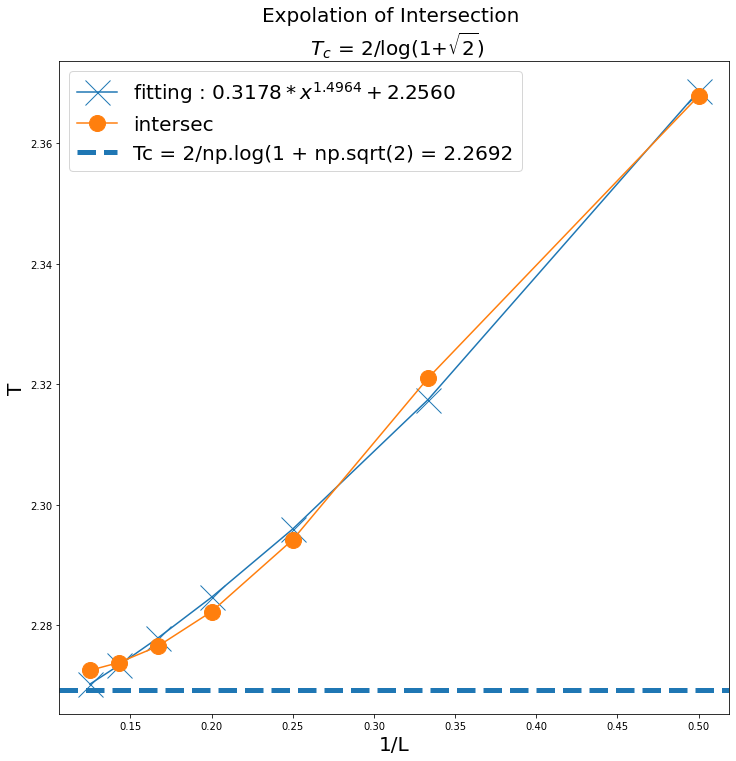

In [15]:
def func(x, a, mu, pc):
    return a * x ** mu + pc

popt, pcov = curve_fit(func, L_inverse, Xintersection, maxfev=40000)
y = func(L_inverse[:],*popt) 

plt.figure(figsize=(12,12))
plt.plot(L_inverse[:],y[:],"-x", label = "fitting : $%.4f*x^{%.4f}+%.4f$" %(popt[0],popt[1],popt[2]),markersize=25)
plt.plot(L_inverse,Xintersection,"-o", label = "intersec",markersize=16)
plt.title("Expolation of Intersection \n $T_c$ = 2/log(1+$\sqrt{2}$)", fontsize = 20)
plt.axhline(y=2/np.log(1 + np.sqrt(2)), ls = "--", linewidth = 5 ,label = "Tc = 2/np.log(1 + np.sqrt(2) = %.4f" %(2/np.log(1 + np.sqrt(2))))
plt.xlabel("1/L", fontsize = 20)
plt.ylabel("T", fontsize = 20)
plt.legend(loc = "best", fontsize=20)

### Y Merge with Xtruncation & Temperature Iterartion

In [16]:
EIGVLE_dic_Ytruncate = {}
Uni_T_trace_dic = {}
Uni_T_dic_Ytruncate = {}


In [36]:
L = 9
Dcut = 16

Lylist = np.linspace(1,L,L,dtype=int)
t = np.linspace(1,3,81)

corrY_truncate = np.zeros((len(Lylist),len(t)),dtype=float)
lambdaY_truncate = np.zeros((len(Lylist),len(t),2),dtype=float)

for t_i in range(len(t)):
    Uni_T, y = T(t[t_i])
    TU = Uni_T.clone()
    TD = Uni_T.clone()
    TL = Uni_T.clone()
    TR = Uni_T.clone()
    
    for y_i in range(len(Lylist)):
        Ly = Lylist[y_i]
        if(Ly == 1):
            Uni_T_temp = TD.clone()
            # Uni_T_dic_Ytruncate[(Ly)] = TD.clone()
            maxBond = np.max(np.shape(Uni_T_temp.get_block().numpy()))
            if(t_i==0):
                print("t_i:", t[t_i])
                print("maxBond",maxBond)
            Uni_I = Identiy(1)
            UniTrace = cy.Network("./network/Ytrace.net")
            UniTrace.PutUniTensors(['T','I'], [Uni_T_temp,Uni_I])
            Uni_T_temp_Trace = UniTrace.Launch()
            # Uni_T_trace_dic[(Ly)] = Uni_T_temp_Trace.clone()

            e, v = la.eigh(Uni_T_temp_Trace.get_block().numpy())
            EIGVLE_dic_Ytruncate[(Ly,t_i)] = e

            lambdaY_truncate[y_i,t_i,0] = np.sort(e)[-1]
            lambdaY_truncate[y_i,t_i,1] = np.sort(e)[-2]
            E0 = -np.log(lambdaY_truncate[y_i,t_i,0])
            E1 = -np.log(lambdaY_truncate[y_i,t_i,1])
            corrY_truncate[y_i,t_i] = 1/(E1-E0)
            # corr1[y_i,t_i] = 1/(np.log(Lambda[y_i,0]/Lambda[y_i,1]))
        elif(maxBond < Dcut):
            # Uni_T_temp1 = Uni_T_temp.clone()
            Uni_T_temp = Ymerge(TU,Uni_T_temp.clone())
            # Uni_T_dic_Ytruncate[(Ly)] = Uni_T_temp.clone()
            maxBond = np.max(np.shape(Uni_T_temp.get_block().numpy()))
            if(t_i==0):
                print("t_i:", t[t_i])
                print("maxBond",maxBond)
            Uni_I = Identiy(1)
            Trace_network = cy.Network("./network/Ytrace.net")
            Trace_network.PutUniTensors(['T','I'], [Uni_T_temp,Uni_I])
            Uni_T_temp_Trace = Trace_network.Launch()

            # Uni_T_trace_dic[(Ly)] = Uni_T_temp_Trace.clone()
            e, v = la.eigh(Uni_T_temp_Trace.get_block().numpy())  
            EIGVLE_dic_Ytruncate[(y_i,t_i)] = e

            lambdaY_truncate[y_i,t_i,0] = np.sort(e)[-1]
            lambdaY_truncate[y_i,t_i,1] = np.sort(e)[-2]
            E0 = -np.log(lambdaY_truncate[y_i,t_i,0])
            E1 = -np.log(lambdaY_truncate[y_i,t_i,1])
            corrY_truncate[y_i,t_i] = 1/(E1-E0)
            # corr1[y_i,t_i] = 1/(np.log(lambda_truncate[y_i,0]/lambda_truncate[y_i,1]))
        else:
            Uni_to_be_truncate_In_X = Ymerge(TU,Uni_T_temp)
            Uni_to_be_truncate_In_X.set_name("Uni_to_be_truncate_In_X")

            Uni_to_be_SVD = Uni_to_be_truncate_In_X.clone()
            # Uni_to_be_SVD.print_diagram()
            Uni_to_be_SVD.permute_([1,0,3,2], rowrank = 1, by_label = True)
            # Uni_to_be_SVD.print_diagram()

            Uni_to_be_SVD.combineBonds([0,3,2])
            Uni_to_be_SVD.set_name("Uni_to_be_SVD")

            # Uni_to_be_SVD.print_diagram()

            S,U,Vd = cy.linalg.Svd_truncate(Uni_to_be_SVD, keepdim=16)
            S.set_name("S_x")
            U.set_name("U_x")
            # U.print_diagram()

            U_dagger = U.Dagger().clone()
            U_dagger.set_name("U_dagger_x")
            # U_dagger.print_diagram()


            network_Xtruncate = cy.Network("network/Xtruncation.net")
            network_Xtruncate.PutUniTensors(["Uni_to_be_truncate_In_X","U","UD"],[Uni_to_be_truncate_In_X,U,U_dagger])
            X_truncated = network_Xtruncate.Launch()
            Uni_T_temp = X_truncated.clone()
                    
            maxBond = np.max(np.shape(X_truncated.get_block().numpy()))
            if(t_i==0):
                print("t_i:", t[t_i])
                print("maxBond",maxBond)            
            network_Ytrace = cy.Network("./network/Ytrace.net")
            I = Identiy(1)
            network_Ytrace.PutUniTensors(['T','I'], [X_truncated,I])
            X_truncated_trace = network_Ytrace.Launch()
            # X_truncated_trace.print_diagram()

            e,v = la.eigh(X_truncated_trace.get_block().numpy())

            EIGVLE_dic_Ytruncate[(y_i,t_i)] = e

            lambdaY_truncate[y_i,t_i,0] = np.sort(e)[-1]
            lambdaY_truncate[y_i,t_i,1] = np.sort(e)[-2]

            E0 = -np.log(lambdaY_truncate[y_i,t_i,0])
            E1 = -np.log(lambdaY_truncate[y_i,t_i,1])

            corrY_truncate[y_i,t_i] = 1/(E1-E0)
            # corr1[y_i,t_i] = 1/(np.log(Lambda[y_i,0]/Lambda[y_i,1]))
            # e,v = la.eigh(X_truncated_trace.get_block().numpy())
            # print(np.log(e[-1]/e[-2]))

t_i: 1.0
maxBond 2
maxBond 4
maxBond 8
maxBond 16
maxBond 16
maxBond 16
maxBond 16
maxBond 16
maxBond 16
t_i: 1.025
t_i: 1.05
t_i: 1.075
t_i: 1.1
t_i: 1.125
t_i: 1.15
t_i: 1.175
t_i: 1.2
t_i: 1.225
t_i: 1.25
t_i: 1.275
t_i: 1.3
t_i: 1.325
t_i: 1.35
t_i: 1.375
t_i: 1.4
t_i: 1.425
t_i: 1.45
t_i: 1.475
t_i: 1.5
t_i: 1.525
t_i: 1.55
t_i: 1.5750000000000002
t_i: 1.6
t_i: 1.625
t_i: 1.65
t_i: 1.675
t_i: 1.7000000000000002
t_i: 1.725
t_i: 1.75
t_i: 1.775
t_i: 1.8
t_i: 1.8250000000000002
t_i: 1.85
t_i: 1.875
t_i: 1.9
t_i: 1.925
t_i: 1.9500000000000002
t_i: 1.975
t_i: 2.0
t_i: 2.0250000000000004
t_i: 2.05
t_i: 2.075
t_i: 2.1
t_i: 2.125
t_i: 2.1500000000000004
t_i: 2.175
t_i: 2.2
t_i: 2.225
t_i: 2.25
t_i: 2.2750000000000004
t_i: 2.3
t_i: 2.325
t_i: 2.35
t_i: 2.375
t_i: 2.4000000000000004
t_i: 2.425
t_i: 2.45
t_i: 2.475
t_i: 2.5
t_i: 2.5250000000000004
t_i: 2.55
t_i: 2.575
t_i: 2.6
t_i: 2.625
t_i: 2.6500000000000004
t_i: 2.675
t_i: 2.7
t_i: 2.725
t_i: 2.75
t_i: 2.7750000000000004
t_i: 2.8
t_i: 2.

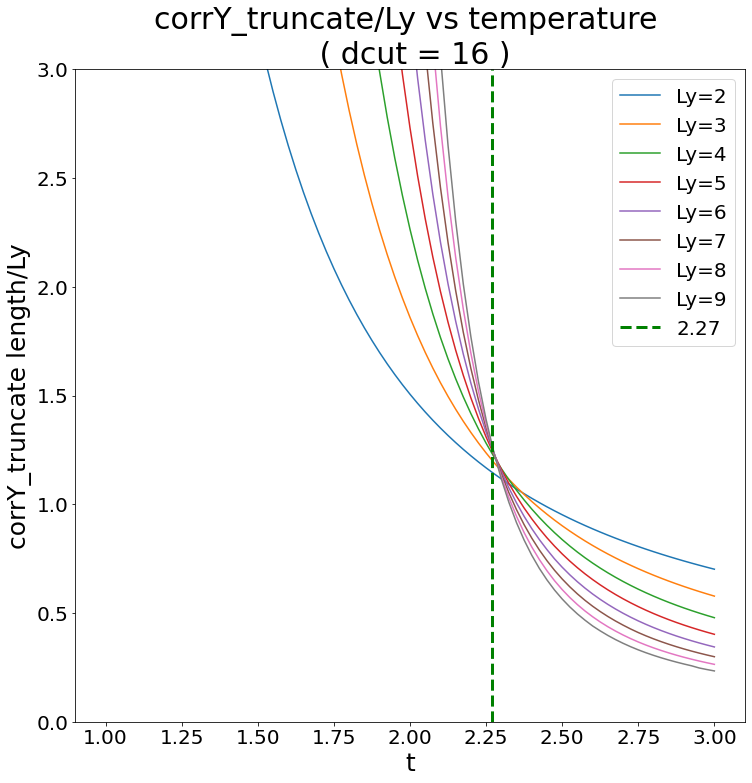

In [19]:
plt.figure(figsize = (12,12))
plt.title("corrY_truncate/Ly vs temperature \n ( dcut = %d )" %(Dcut), fontsize = 30)

for l in range(1,len(Lylist)):
    plt.plot(t[:], corrY_truncate[l,:]/Lylist[l], label = "Ly=%d" %(Lylist[l]))

# plt.xlim(2,3)
plt.axvline(x=2.27,c='green',ls='--',lw=3,label="2.27")
plt.xticks(fontsize = 20 )
plt.xlabel("t",fontsize = 25)
plt.ylim(0,3)
plt.yticks(fontsize = 20 )
plt.ylabel("corrY_truncate length/Ly",fontsize = 25)
plt.legend(fontsize = 20)

### Search T* Intersection & Expolation ( Y merge and X truncation )

In [20]:
Xintersection = np.zeros(len(corr[:,0]) - 1)
Yintersection = np.zeros(len(corr[:,0]) - 1)
L_inverse = []

for l in range(1,len(Lylist)-1):
    Ly1 = Lylist[l]
    Ly2 = Lylist[l+1]
    # print("l",l)
    # print("Ly1",Ly1)
    # print("Ly2",Ly2)

    L_inverse.append(1/Ly1)
    for t_i in range(len(t)-1):

        if((corrY_truncate[l+1,t_i]/Ly2-corrY_truncate[l,t_i]/Ly1)*(corrY_truncate[l+1,t_i+1]/Ly2-corrY_truncate[l,t_i+1]/Ly1) < 0):

            y=[corrY_truncate[l+1,t_i]/Ly2,corrY_truncate[l+1,t_i+1]/Ly2]
            x=[t[t_i],t[t_i+1]]
            
            y1=[corrY_truncate[l,t_i]/Ly1,corrY_truncate[l,t_i+1]/Ly1]
            x1=[t[t_i],t[t_i+1]]

            print("x1:",x1)

            fit1 = np.polyfit(x,y,1)
            fit2 = np.polyfit(x1,y1,1)

            root = np.roots(fit1-fit2)
            Xintersection[l-1]=root[0]

            break
        
# Xintersection = Xintersection[1:]
Xintersection = Xintersection[:-1]
# L_inverse = L_inverse[:-1]

x1: [2.35, 2.375]
x1: [2.3, 2.325]
x1: [2.2750000000000004, 2.3]
x1: [2.2750000000000004, 2.3]
x1: [2.2750000000000004, 2.3]
x1: [2.2750000000000004, 2.3]
x1: [2.2750000000000004, 2.3]


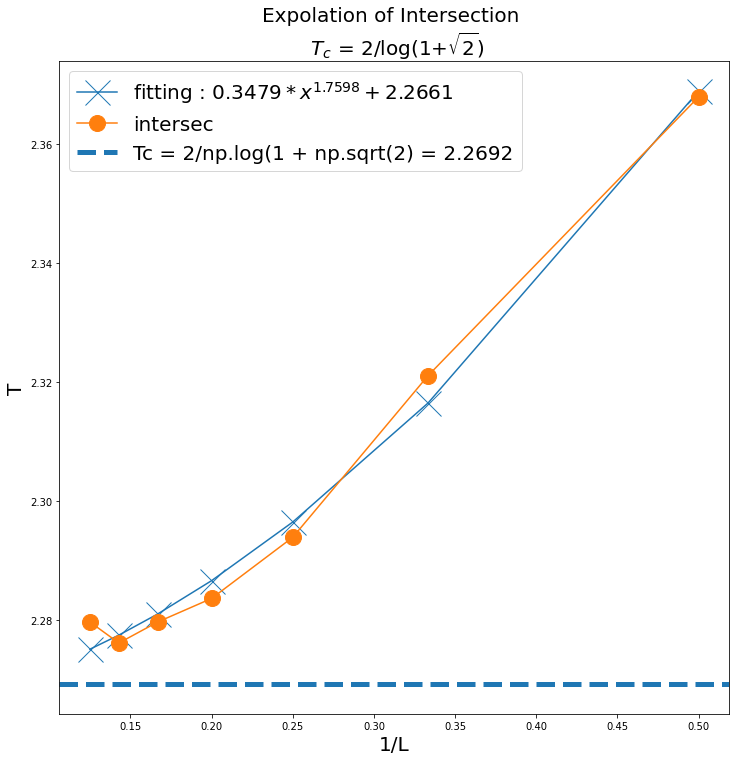

In [22]:
def func(x, a, mu, pc):
    return a * x ** mu + pc

popt, pcov = curve_fit(func, L_inverse, Xintersection, maxfev=40000)
y = func(L_inverse[:],*popt) 

plt.figure(figsize=(12,12))
plt.plot(L_inverse[:],y[:],"-x", label = "fitting : $%.4f*x^{%.4f}+%.4f$" %(popt[0],popt[1],popt[2]),markersize=25)
plt.plot(L_inverse,Xintersection,"-o", label = "intersec",markersize=16)
plt.title("Expolation of Intersection \n $T_c$ = 2/log(1+$\sqrt{2}$)", fontsize = 20)
plt.axhline(y=2/np.log(1 + np.sqrt(2)), ls = "--", linewidth = 5 ,label = "Tc = 2/np.log(1 + np.sqrt(2) = %.4f" %(2/np.log(1 + np.sqrt(2))))
plt.xlabel("1/L", fontsize = 20)
plt.ylabel("T", fontsize = 20)
plt.legend(loc = "best", fontsize=20)

### Dictionary to Store Tensor

In [23]:
Uni_T_dic_XY = {}
Uni_T_trace_dic_XY = {}
EIGVLE_dic_XY = {}

### Contraction in both direction

#### $T_{x=1,y=1},T_{x=2,y=2},T_{x=4,y=4}$

In [24]:
List = [1,2,4]

TU = Uni_T.clone()
TD = Uni_T.clone()
TL = Uni_T.clone()
TR = Uni_T.clone()

for y in List:
    if(y == 1):
        Uni_T_temp = TD
        # Uni_T_temp2.print_diagram()
        Uni_T_dic_XY[(y,y)] = TU.clone()
        Uni_T_trace_dic_XY[(y,y)] = TU.Trace(0,3).clone()
        e, v  = la.eigh(TU.Trace(0,3).get_block().numpy())
        # print("EIGVLE_T_trace",EIGVLE_T_trace)
        EIGVLE_dic_XY[(y,y)] = e
    else:
        Uni_T_temp_TU = Uni_T_temp.clone()
        Uni_T_temp_TD = Uni_T_temp.clone()
        Uni_T_temp_TL = Ymerge(Uni_T_temp_TU,Uni_T_temp_TD)
        Uni_T_temp_TR = Uni_T_temp_TL.clone()
        Uni_T_temp = Xmerge(Uni_T_temp_TL,Uni_T_temp_TR)
        Uni_T_dic_XY[(y,y)] = Uni_T_temp.clone()
        Uni_T_trace_dic_XY[(y,y)] = Uni_T_temp.Trace(0,3).clone()
        EIGVLE_dic_XY[(y,y)], v = la.eigh(Uni_T_temp.Trace(0,3).get_block().numpy())    
        print("EIGVLE_dic_XY[(%d,%d)]" %(y,y),EIGVLE_dic_XY[(y,y)])
        # print("EIGVLE_dic[(1,y_i)]",EIGVLE_dic[(1,y)][-1],EIGVLE_dic[(1,y)][-2],EIGVLE_dic[(1,y)][-3],EIGVLE_dic[(1,y)][-4])


EIGVLE_dic_XY[(2,2)] [ 0.13044463  0.54228917  7.80458031 32.44548498]
EIGVLE_dic_XY[(4,4)] [6.19870062e-04 5.00396552e-03 1.91405191e-01 1.91405191e-01
 6.61187700e-01 1.03645761e+00 1.79126969e+01 1.79126969e+01
 1.79126969e+01 1.79126969e+01 3.09578229e+02 4.85285360e+02
 1.67636369e+03 1.67636369e+03 6.41220868e+04 5.17632201e+05]


### Temperature Iteration & X,Y iteration

In [53]:
Llist = [1,2,4]
t = np.linspace(1,3,81)

corrXY = np.zeros((len(Llist),len(t)),dtype=float)
LambdaXY = np.zeros((len(Llist),len(t),2),dtype=float)

for t_i in range(len(t)):
    Uni_T, Cy_T = T(t[t_i])
    TU = Uni_T.clone()
    TD = Uni_T.clone()
    TL = Uni_T.clone()
    TR = Uni_T.clone()

    Uni_T_dic_XY = {}
    Uni_T_trace_dic_XY = {}
    EIGVLE_dic_XY = {}

    for y_i in range(len(Llist)):

        Ly = Llist[y_i]
        if(y_i==0):
            Uni_T_temp = Uni_T.clone()
            if(t_i==0):
                print("LxLy:",Ly,Ly)
            Uni_T_dic_XY[(Ly,Ly)] = Uni_T_temp.clone()
            Uni_T_trace_dic_XY[(Ly,Ly)] = Uni_T_temp.Trace(0,3).clone()
            EIGVLE_T_trace, v = la.eigh(Uni_T_temp.Trace(0,3).get_block().numpy()) 
            EIGVLE_dic_XY[(Ly,Ly)] = EIGVLE_T_trace
            LambdaXY[y_i,t_i,0] = np.sort(EIGVLE_dic_XY[(Ly,Ly)])[-1]
            LambdaXY[y_i,t_i,1] = np.sort(EIGVLE_dic_XY[(Ly,Ly)])[-2]
            corrXY[y_i,t_i] = 1/np.log(LambdaXY[y_i,t_i,0]/LambdaXY[y_i,t_i,1])

            # Lambda[y_i,0] = np.sort(EIGVLE_dic[(1,Ly)])[-1]
            # Lambda[y_i,1] = np.sort(EIGVLE_dic[(1,Ly)])[-2]
            # E0 = -np.log(Lambda[y_i,0])
            # E1 = -np.log(Lambda[y_i,1])
            # corr[y_i,t_i] = 1/(E1-E0)
            # corr1[y_i,t_i] = 1/(np.log(Lambda[y_i,0]/Lambda[y_i,1]))
        else:
            if(t_i==0):
                print("LxLy:",Ly,Ly)    

            if(Ly>4):
                Uni_T_temp = Uni_T_temp/np.max(Uni_T_temp.get_block().numpy())     
                
            Uni_T_temp_TD = Uni_T_temp.clone()
            Uni_T_temp_TU = Uni_T_temp.clone()
            Uni_T_temp_TL = Ymerge(Uni_T_temp_TU,Uni_T_temp_TD)
            Uni_T_temp_TR = Uni_T_temp_TL.clone()
            Uni_T_temp = Xmerge(Uni_T_temp_TL,Uni_T_temp_TR)
            Uni_T_dic_XY[(Ly,Ly)] = Uni_T_temp.clone()
            Uni_T_trace_dic_XY[(Ly,Ly)] = Uni_T_temp.Trace(0,3).clone()
            EIGVLE_T_trace, v = la.eigh(Uni_T_temp.Trace(0,3).get_block().numpy()) 
            EIGVLE_dic_XY[(Ly,Ly)] = EIGVLE_T_trace            
            LambdaXY[y_i,t_i,0] = np.sort(EIGVLE_dic_XY[(Ly,Ly)])[-1]
            LambdaXY[y_i,t_i,1] = np.sort(EIGVLE_dic_XY[(Ly,Ly)])[-2]
            corrXY[y_i,t_i] = 1/np.log(LambdaXY[y_i,t_i,0]/LambdaXY[y_i,t_i,1])
            # print("shape:",np.shape(Uni_T_dic1[(y_i,y_i)].get_block().numpy())) 

LxLy: 1 1
LxLy: 2 2
LxLy: 4 4


### Check with Y Iteration Case

size: 2
size: 4


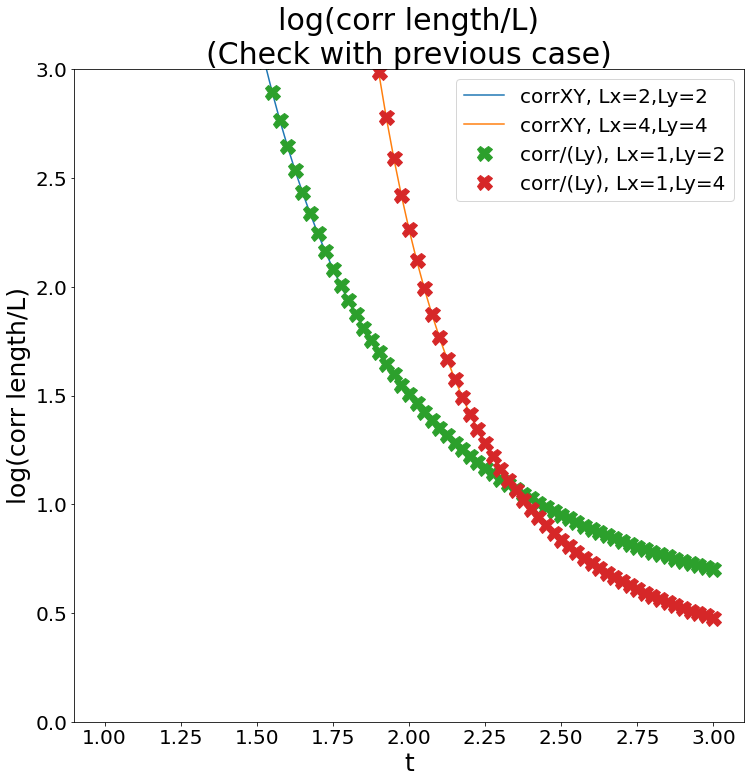

In [54]:
plt.figure(figsize = (12,12))
plt.title("log(corr length/L)\n(Check with previous case)", fontsize = 30)

for l in range(1,3):
    size = Llist[l]
    print("size:", size)
    plt.plot(t[:], corrXY[l,:], label = "corrXY, Lx=%d,Ly=%d" %(size,size))
    
for l in range(1,len(Llist)):
    size = Llist[l]
    plt.plot(t[:], corr[size-1,:]/(size), "X", markersize = 15, label = "corr/(Ly), Lx=1,Ly=%d" %(size) )

# plt.xlim(2.2,2.3)
plt.xticks(fontsize = 20 )
plt.xlabel("t",fontsize = 25)
plt.ylim(0,3)
plt.yticks(fontsize = 20 )
plt.ylabel("log(corr length/L)",fontsize = 25)
plt.legend(fontsize = 20)